# Stock Trades by Members of the US House of Representatives

* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    - Can you predict the party affiliation of a representative from their stock trades?
    - Can you predict the geographic region that the representative comes from using their stock trades? E.g., west coast, east coast, south, etc.
    * Can you predict whether a particular trade is a BUY or SELL?

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
The prediction problem we are investigating is `'Can you predict the geographic region that the representative comes from using their stock trades`. The problem is a classification problem since the prediction we want to make is categorical(five different geographic region of the United States). The target variables are the regions that representative comes from, and this information is extracted from the district that each representative come from. We classified the districts into 5 geographic group - West, Southwest, Midwest, Southeast, and Northeast. We choose f1-score with **average='weighted'** because there is uneven distribution of data points for each region. The weighted keyward means that the metric takes the mean of all per-region f1 scores while considering the proportion of each region in the dataframe.  


### Baseline Model
We use 6 features to build on our baseline model.There are 1 quantitative feature:`"avg_amount"` and 5 nominal features: `'type', 'owner', 'ticker', 'current_party', 'cap_gains_over_200_usd'`. The weighted f1 score for our baseline model is `0.530822413161542`, which indicates that there is a lot to improve for this model.  

### Final Model
The first new features we added into our final models is the `standardized avg_amount by current_party group`, since the party is definitely an important feature for predicting the region for each representatives, and there might be uneven spread of average amount between the two parties. The second feature we added is `the month in which the transaction is made`, as there might be seasonal effects for each region's economy. Our final model is a **RandomForestClassifier**. This model fits a number of decision tree classifiers on various sub-samples of the dataset, which largely improve the accuracy. After performing the gridsearchCV, the parameters that end up performing best are **n_estimators = 400** and **max_depth = None**. Our final weighted f1_score on the test sets is `0.8732408626223951`, which is very similar to our score on the trained set, indicating our model is correctly fitted. 
   
### Fairness Evaluation 🤔
We want to test whethwe our model is fairer for Democratics or Republicans, as party affiliation is directly related to the region of the representative(red states and blue states!), and there are much more data points for Democrats than Republicans. Thus our hypothesis are:


Null Hypothesis: our model is fair; the accuracy for the two different political party(Republican,Democratic) are roughly the same.


Alternative Hypothesis: out model is unfair; the precision for the Republican subset is different from the Democratic subset.

During the permutation test, we shuffled the current_party column and calculate the unsigned difference in f1_score for different party in each shuffled dataframe. 
The resulting p-value for the permutation test is 0.0. Thus we reject the null hypothesis. There is bias in our model regarding the political affiliation. 

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import Binarizer
from sklearn import metrics

from StdScalerByGroup import StdScalerByGroup
import warnings
warnings.simplefilter('ignore')

### Baseline Model

In [7]:
# We first read in the data we cleaned in project 3, with the party affiliation and the calculated average amount for 
# each transaction
swp = pd.read_csv('stock_with_party.csv')
swp.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,current_party,avg_amount
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,8000.0
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,8000.0
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,32500.0
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,32500.0
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,Democratic,8000.0


Since we want to predict the region for each representative, we first need to group them into the 5 geographic regions. This is achieved by extracting the state information from the district column.

In [9]:
west = ['CO', 'WY', 'MT', 'ID', 'WA', 'OR', 'UT', 'NV', 'CA', 'AK', 'HI']
southwest = ['TX', 'OK', 'NM', 'AZ']
midwest = ['OH', 'IN', 'M', 'IL', 'MO', 'WI', 'MN', 'IA', 'KS', 'NE', 'SD', 'ND']
southeast = ['WV', 'VA', 'KY', 'TN', 'NC', 'SC', 'GA', 'AL', 'MS', 'AR', 'LA', 'FL']
northeast = ['ME', 'MA', 'RI', 'CT', 'NH', 'VT', 'NY', 'PA', 'NJ', 'DE', 'MD']

In [10]:
to_region = swp['district'].str[0:2].apply(lambda x:'west' if x in west 
                                           else 'southwest' if x in southwest 
                                           else 'midwest' if x in midwest
                                          else 'southeast' if x in southeast
                                          else 'northeast')
swp['region'] = to_region
swp.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,current_party,avg_amount,region
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,8000.0,southeast
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,8000.0,southeast
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,32500.0,southeast
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,32500.0,southeast
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,Democratic,8000.0,west


Now we have added the region information. Let's start to train the model.

In [144]:
base_features = ['avg_amount','type', 'owner', 'ticker','current_party', 'cap_gains_over_200_usd']

In [145]:
# Transform the 'owner','type', 'ticker','current_party' columns using OneHotEncoder, since they are
# all categorical; Then transform the 'cap_gains_over_200_usd' with Binarizer since the values are boolean.
base_preproc = ColumnTransformer([
    ('one_hot',  OneHotEncoder(handle_unknown='ignore'), ['owner','type', 'ticker','current_party']),
    ('binary', Binarizer(), ['cap_gains_over_200_usd']),
    ], remainder='passthrough')

In [146]:
# Use RandomForestClassifier as our method for model.
base_pl = Pipeline([
        ('base_pre', base_preproc),
        ('clf', RandomForestClassifier(max_depth=25))
    ])


bX_train, bX_test, by_train, by_test = train_test_split(swp[base_features].fillna('_'), 
                                                    swp.region,
                                                    test_size = 0.25)

In [147]:
base_pl.fit(bX_train, by_train)

Pipeline(memory=None,
         steps=[('base_pre',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('one_hot',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['owner', 'type', 'ticker',
                                                   'current_party']),
                                                 ('binary',
                                                  Binarizer(copy=True

In [150]:
base_predict = base_pl.predict(bX_test)
metrics.f1_score(np.array(by_test), base_predict, average = 'weighted')

0.530822413161542

In [177]:
swp['region'].value_counts(normalize=True)

west         0.305233
southeast    0.297632
northeast    0.205917
southwest    0.097745
midwest      0.093473
Name: region, dtype: float64

From the distribution, we can see that a naive model predicting west for every row will achieve an accuracy of rougly 30.5%, and our baseline model here has an accuracy of 55% which is not much higher. Thus it is not a good performance.

### Final Model

Let's start to improve our model!

In [107]:
features = ['transaction_date', 'avg_amount','type', 'owner', 'ticker', 'current_party', 'cap_gains_over_200_usd']

In [68]:
# First, we extract the month for each transaction through transaction date. 
by_month = Pipeline([
        ('to_month', FunctionTransformer(lambda x:pd.to_datetime(x.iloc[:,0]).dt.month.to_frame(), validate=False)),
        ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ]) #change transaction date to quarter and then onehot encode it

In [74]:
# Using the stdScalarByGroup transformer we defined in lab09 to standardize the 
# avg_amount by party affiliation.
preproc = ColumnTransformer([
        ('to_quarter', by_season, ['transaction_date']),
        ('std', StdScalerByGroup(), ['current_party','avg_amount']),
        ('one_hot',  OneHotEncoder(handle_unknown='ignore'), ['owner','type','ticker', 'current_party']),
        ('binary', Binarizer(), ['cap_gains_over_200_usd'])
        ], remainder='passthrough')
    
pl = Pipeline([
        ('pre', preproc),
        ('clf', RandomForestClassifier())
    ])

In [108]:
X_train, X_test, y_train, y_test = train_test_split(swp[features].fillna('_'), 
                                                    swp.region,
                                                    test_size = 0.18)

In [49]:
# The parameters that we want to test
# Number of trees in random forest
n_estimators = [300, 350, 400, 450, 500]
# Maximum number of levels in tree
max_depth = [20, 30, 40, 50, 60, 70]
max_depth.append(None)

hyperparameters = {
    'clf__n_estimators': n_estimators,
    'clf__max_depth': max_depth}

In [50]:
searcher = GridSearchCV(pl, hyperparameters, cv=3)

In [51]:
searcher.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('to_quarter',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('to_month',
                                                                                          FunctionTransformer(accept_sparse=False,
                                                                                                              check_inverse=True,
         

In [52]:
# The parameters that achieve the best performance
searcher.best_params_

{'clf__max_depth': None, 'clf__n_estimators': 400}

In [81]:
searcher.score(X_train, y_train)

0.8748946602313644

In [82]:
searcher.score(X_test, y_test)

0.8729937194696441

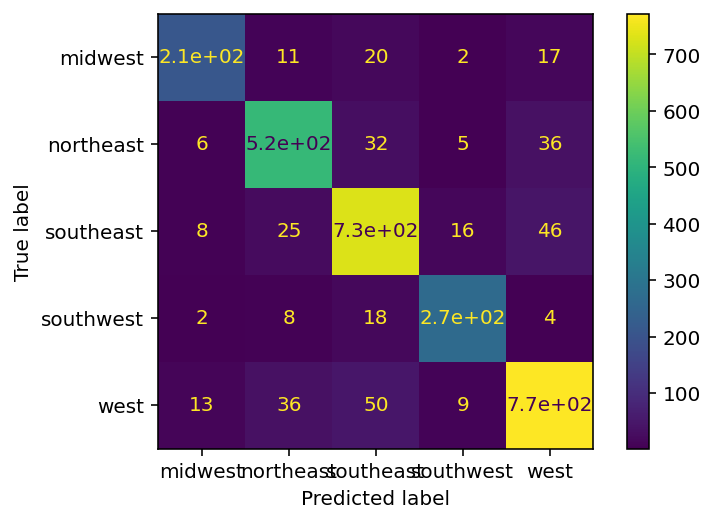

In [89]:
y_pred = searcher.predict(X_test)
abc = metrics.confusion_matrix(y_test, y_pred)
metrics.plot_confusion_matrix(searcher, X_test, y_test)

In [113]:
# The weighted f1 score for the final model
predictions = searcher.predict(X_test)
metrics.f1_score(np.array(y_test), predictions, average='weighted')

0.8732408626223951

That's about 34% increase in our model performance.

### Fairness Evaluation

Null Hypothesis: our model is fair; the accuracy for the two different political party(Republican,Democratic) are roughly the same.

Alternative Hypothesis: out model is unfair; the precision for the Republican subset is different from the Democratic subset.

In [132]:
needed = ['transaction_date', 'avg_amount','type', 'owner', 'ticker', 'current_party', 'cap_gains_over_200_usd', 'region']

In [133]:
X = swp[needed].fillna('_')

In [163]:
blue = X[X['current_party'] == 'Democratic']
blue_pre = searcher.predict(blue[features])
blue_f1 = metrics.f1_score(np.array(blue['region']), blue_pre, average='weighted')

red = X[X['current_party'] == 'Republican']
red_pre = searcher.predict(red[features])
red_f1 = metrics.f1_score(np.array(red['region']), red_pre, average='weighted')

obs_diff = blue_f1-red_f1
obs_diff

-0.009681547461228068

In [170]:
# Performing the permutation test

acc_diff = []
for _ in range(100):
    shuffled = X.assign(current_party=X.current_party.sample(frac=1.0, replace=False).reset_index(drop=True))
    blue = shuffled[shuffled['current_party'] == 'Democratic']
    blue_pre = searcher.predict(blue[features])
    blue_f1 = metrics.f1_score(np.array(blue['region']), blue_pre, average='weighted')
    
    red = shuffled[shuffled['current_party'] == 'Republican']
    red_pre = searcher.predict(red[features])
    red_f1 = metrics.f1_score(np.array(red['region']), red_pre, average='weighted')
    
    diff = blue_f1 - red_f1
    acc_diff.append(diff)

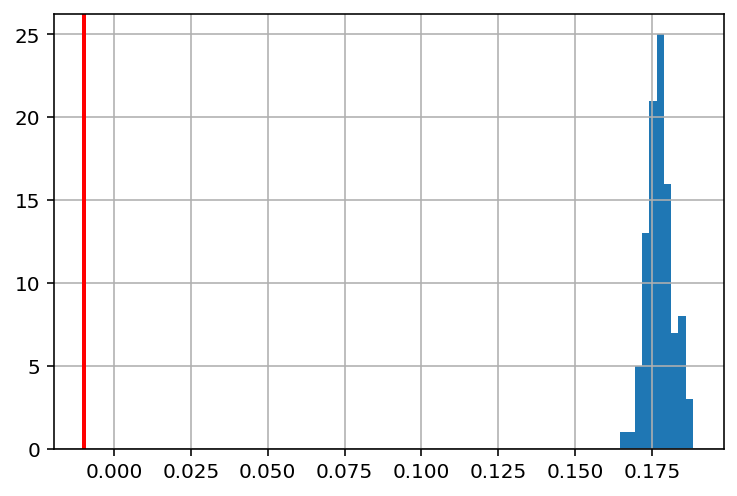

In [166]:
pd.Series(acc_diff).hist()
plt.axvline(x=obs_diff, color='red', linewidth=2);

In [169]:
# The result p-value
np.mean(np.array(acc_diff) <= obs_diff)

0.0

From the graph and calculated p-value, we can see that there is bias between the model accuracy for different political party.